In [1]:
from tools import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import multivariate_normal
from scipy.linalg import fractional_matrix_power
from scipy.stats import wishart
import sys
import time
np.random.seed(121)

In [2]:
def logpdfTarget (x,d,v,covariance_inverse=None):
    if (covariance_inverse is None):
        lnp = -(v+d)/2*np.log(1+1/v*((x.T).dot(x)))
    else:
        lnp = -(v+d)/2*np.log(1+1/v*((x.T).dot(covariance_inverse).dot(x)))
    return(lnp)

In [3]:
v=4
d = 100
Sigma_minus1 = wishart.rvs(df=d,scale=np.eye(d))
cov = v/(v-2) * np.linalg.inv(Sigma_minus1)
Sigma_neg = np.sqrt(v/(v-2)) * fractional_matrix_power(cov,-0.5)
Sigma_pos = np.sqrt((v-2)/v) * fractional_matrix_power(cov,0.5)
# print('True Covariance:')
# print(cov)
begin_total = time.time()
nround = int(10e5)
burnin = int(10e4)
size = len(range(-burnin,nround))
x = np.random.random(d) - 0.5
y = np.zeros(nround*d).reshape(nround,d)
mu_star = 0
target_result = {}

random_1DUniform = (np.random.random(size = size*d)-0.5) * np.sqrt(12)
random_1DNormal = np.random.normal(size = size*d)
random_Normal2D = np.random.multivariate_normal(np.zeros(d),np.eye(d),size = size)
random_Square2D = np.random.uniform(-np.sqrt(3), np.sqrt(3), size = (size,2))
r = np.random.uniform(size = size)
theta = np.random.uniform(low=0.0, high=2*np.pi, size = size)
random_Disc2D = np.array([[2*np.sqrt(r[i])*np.cos(theta[i]), 2*np.sqrt(r[i])*np.sin(theta[i])] for i in range(size)])

targetset = ['N0Sigma']
kernelset_N0Sigma = ['Two1DTransfMirrorU']
sigmaset = np.arange(0.1,2.1,0.1)

for target in targetset:
    kernelset = kernelset_N0I if (target == 'N0I') else kernelset_N0Sigma
    eff_kernel = {}; Pjump_kernel = {}; Exx2_kernel = {}; Rho_kernel={}; Sample_kernel={}
    for kernel in kernelset:
        cov = None if ((target == 'N0I') | ('Trans' in kernel)) else cov_inv
        Eff = []; Pjump = []; Exx2=[]; Rho=[]; Sample=[]
        for sigma in sigmaset:
            begin_loop = time.time()
            exx2 = 0; accept = np.zeros(d)
            for j in range(-burnin,nround):
                if (j==0):
                    accept = np.zeros(d);
                for i in range(d):
                    initial = x.copy()
                    pi_old = logpdfTarget(initial,d,v,cov)
                    if ('Uniform' in kernel):
                        initial[i] += random_1DUniform[(j+burnin)*d+i] * sigma    #Uniform
                    elif ('Gaussian' in kernel):
                        initial[i] += random_1DNormal[(j+burnin)*d+i] * sigma     #Gaussian
                    elif ('Mirror' in kernel):
                        NewCenter = 2*mu_star - initial[i]
                        initial[i] = NewCenter + random_1DUniform[(j+burnin)*d+i] * sigma    #Mirror Uniform
                    else:
                        sys.exit('No such kernel exists')
                    pi_new = logpdfTarget(initial,d,v,cov)
                    pi_dif = pi_new - pi_old
                    if ((pi_dif>0) | (np.exp(pi_dif)>np.random.random())):
                        x = initial
                        accept[i] += 1     
                if (j>=0):
                    y[j,:] = np.dot(Sigma_pos,x) if 'Trans' in kernel else x
            eff = Eff_IntegratedCorrelationTime(y[:,0])
            exx2 = sum(np.square(y[:,0][1:] - y[:,0][:-1]))
            rho = [rho_k(y[:,0],i) for i in range(1,11)]
            Eff.append(eff)
            Pjump.append(accept[0]/nround)
            Rho.append(rho)
            Exx2.append(exx2/nround)
            Sample.append(y[:,0].copy())
            print ('sigma:',sigma,'|eff:',round(eff,4), '|Pjump:', round(accept[0]/nround,4), '|Exx2:', round(exx2/nround,4),
                   '|rho1:', round(rho[0],4), '|rho2:', round(rho[1],4) ,'|Time:',round((time.time()-begin_loop),2),sep='')
        eff_kernel[kernel] = Eff
        Pjump_kernel[kernel] = Pjump
        Exx2_kernel[kernel] = Exx2
        Rho_kernel[kernel] = Rho
        Sample_kernel[kernel] = Sample
    target_result[target] = [eff_kernel,Pjump_kernel,Exx2_kernel,Rho_kernel,Sample_kernel]
# print('sample cov:')
# print(np.cov(np.vstack([y[:,i] for i in range(d)])))
print('总共用时: %f'% (time.time()-begin_total))

sigma:0.1|eff:-3.1654|Pjump:0.9678|Exx2:6.3972|rho1:-0.9049|rho2:0.8212|Time:1156.87
sigma:0.2|eff:-12.5531|Pjump:0.9361|Exx2:6.7078|rho1:-0.826|rho2:0.6912|Time:1142.23
sigma:0.30000000000000004|eff:15.7677|Pjump:0.9029|Exx2:6.1152|rho1:-0.7439|rho2:0.5696|Time:1128.26
sigma:0.4|eff:5.953|Pjump:0.8707|Exx2:5.7331|rho1:-0.6627|rho2:0.4623|Time:1150.58
sigma:0.5|eff:4.254|Pjump:0.8384|Exx2:5.6302|rho1:-0.595|rho2:0.3834|Time:1111.01
sigma:0.6|eff:3.2003|Pjump:0.8082|Exx2:5.4484|rho1:-0.531|rho2:0.3189|Time:1136.12
sigma:0.7000000000000001|eff:2.6727|Pjump:0.7771|Exx2:5.1397|rho1:-0.4697|rho2:0.2669|Time:1168.16
sigma:0.8|eff:2.9526|Pjump:0.755|Exx2:6.5901|rho1:-0.4946|rho2:0.3126|Time:1136.48
sigma:0.9|eff:2.4563|Pjump:0.7252|Exx2:6.3463|rho1:-0.4433|rho2:0.275|Time:1136.21
sigma:1.0|eff:1.711|Pjump:0.6967|Exx2:4.791|rho1:-0.3127|rho2:0.1627|Time:1154.56
sigma:1.1|eff:1.5637|Pjump:0.6701|Exx2:4.8301|rho1:-0.2855|rho2:0.1618|Time:1148.31
sigma:1.2000000000000002|eff:1.4597|Pjump:0.6483|E

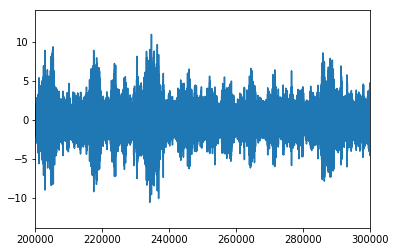

In [22]:
plt.plot(target_result['N0Sigma'][4]['Two1DTransfMirrorU'][3])
plt.xlim(200000,300000)
plt.savefig('100Normal_TrueMean_TracePlot0.1.eps', format='eps', dpi=1000)
plt.show()

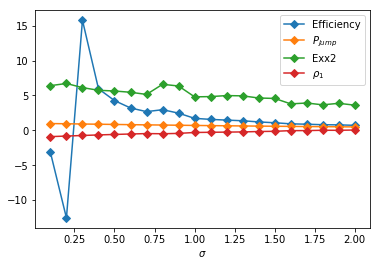

In [20]:
target_result['N0Sigma'][0]['Two1DTransfMirrorU']
label = ['Efficiency','$P_{jump}$','Exx2']
rho1 = [target_result['N0Sigma'][3]['Two1DTransfMirrorU'][i][0] for i in range(len(sigmaset))]
[plt.plot(sigmaset,target_result['N0Sigma'][i]['Two1DTransfMirrorU'],marker='D',label=label[i]) for i in range(3)]
plt.plot(sigmaset,rho1,marker='D',label='$\\rho_1$')
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.savefig('100Normal_TrueMean0.1.eps', format='eps', dpi=1000)
plt.show()

In [4]:
np.save('100D_tdistri_result',target_result)